<h1>EyeT4Empathy with ML Development</h1>

In [ ]:
# import required librqry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import glob
import sys


from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, GroupKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score

import pickle

warnings.filterwarnings("ignore")

<h2>Import Dataset</h2>

In [ ]:
# Get the .csv file names as a list

csv_files = glob.glob('EyeT/*.csv')

# get the number of csv files
files_count = len(csv_files)
print ("CSV Files : ", files_count)


CSV Files :  502


In [ ]:
def preprocess_raw_empathy_data(data):
    # Drop the first column
    data = data.iloc[:, 1:]

    # List of columns to drop if they exist not important for Empathy
    cols_to_drop = ['Mouse position X', 'Mouse position Y', 'Fixation point X (MCSnorm)', 'Fixation point Y (MCSnorm)',
                    'Event', 'Event value',
                    'Computer timestamp', 'Export date', 'Recording date',
                    'Recording date UTC', 'Recording start time', 'Timeline name', 'Recording Fixation filter name',
                    'Recording software version', 'Recording resolution height', 'Recording resolution width',
                    'Recording monitor latency', 'Presented Media width', 'Presented Media height',
                    'Presented Media position X (DACSpx)', 'Presented Media position Y (DACSpx)', 'Original Media width',
                    'Recording start time UTC', 'Original Media height', 'Sensor']


    # Forward fill the pupil diameter and fixation point columns
    data[['Pupil diameter left', 'Pupil diameter right', 'Fixation point X', 'Fixation point Y']] = \
        data[['Pupil diameter left', 'Pupil diameter right', 'Fixation point X', 'Fixation point Y']].ffill()

    # List of columns to be converted to numerical values
    num_cols = ['Gaze direction left X', 'Gaze direction left Y', 'Gaze direction left Z',
                'Gaze direction right X', 'Gaze direction right Y', 'Gaze direction right Z',
                'Eye position left X (DACSmm)', 'Eye position left Y (DACSmm)', 'Eye position left Z (DACSmm)',
                'Eye position right X (DACSmm)', 'Eye position right Y (DACSmm)', 'Eye position right Z (DACSmm)',
                'Gaze point left X (DACSmm)', 'Gaze point left Y (DACSmm)', 'Gaze point right X (DACSmm)',
                'Gaze point right Y (DACSmm)', 'Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)',
                'Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)',
                'Gaze point right Y (MCSnorm)', 'Pupil diameter left', 'Pupil diameter right']

    # Convert the string values into numbers
    for col in num_cols:
        data[col] = pd.to_numeric(data[col].str.replace(',', '.'), errors='coerce')


    return data

def group_eye_tracking_data(data, group):

    valid_data = data[(data['Validity left'] == 'Valid') & (data['Validity right'] == 'Valid')]


    total_fixations = data[data['Eye movement type'] == 'Fixation'].shape[0]


    avg_fixation_duration = data[data['Eye movement type'] == 'Fixation']['Gaze event duration'].mean()

    # Calculate mean, median, and std of pupil diameter, Gaze point X, Gaze point Y, Fixation point X, and Fixation point Y
    pupil_diameter_stats = data[['Pupil diameter left', 'Pupil diameter right']].mean(axis=1).agg(['mean', 'median', 'std']).rename(lambda x: f'Pupil Diameter {x.capitalize()}')
    gaze_point_x_stats = data['Gaze point X'].agg(['mean', 'median', 'std']).rename(lambda x: f'Gaze Point X {x.capitalize()}')
    gaze_point_y_stats = data['Gaze point Y'].agg(['mean', 'median', 'std']).rename(lambda x: f'Gaze Point Y {x.capitalize()}')
    fixation_point_x_stats = data['Fixation point X'].agg(['mean', 'median', 'std']).rename(lambda x: f'Fixation Point X {x.capitalize()}')
    fixation_point_y_stats = data['Fixation point Y'].agg(['mean', 'median', 'std']).rename(lambda x: f'Fixation Point Y {x.capitalize()}')

    # Create summary row
    summary_data = {
        'Participant Name': data['Participant name'].iloc[0],
        'Experiment Group': group,
        'Recording Name': data['Recording name'].iloc[0],
        'Total Fixations': total_fixations,
        'Avg. Fixation Duration': avg_fixation_duration
    }
    summary_data.update(pupil_diameter_stats)
    summary_data.update(gaze_point_x_stats)
    summary_data.update(gaze_point_y_stats)
    summary_data.update(fixation_point_x_stats)
    summary_data.update(fixation_point_y_stats)

    summary = pd.DataFrame(summary_data, index=[0])

    return summary

# This function preprocess data into Test and Control group experiment
def preprocess_empathy_data(files):

    # Declare an empty list to store as dataframe
    eye_list_df = list()
    #initalise a loop
    loop = 0

    # Loop throught files
    for file in files:
        raw_data = pd.read_csv(file, usecols=lambda column: column != 0, low_memory=True)

        # Apply the preprocessing function to the data
        processed_data = preprocess_raw_empathy_data(raw_data)

        file_name = os.path.basename(file)

        if file_name.startswith('EyeT_group_dataset_III_'):
            group = 'Test Group'
        else:
            group = 'Control Group'

        # Apply the summarize_eye_tracking_data function to the data
        summary = group_eye_tracking_data(processed_data, group)
        eye_list_df.append(summary)

        loop += 1

    # combine all dataframes into one dataframe
    eyes_df = pd.concat(eye_list_df, ignore_index=True)

    return eyes_df

In [ ]:
# Preprocess empathy data
empathy_processed_data = preprocess_empathy_data(csv_files)
empathy_processed_data.head()

,Participant Name,Experiment Group,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std
0,Participant0019,Test Group,Recording7,12745,455.327187,2.895178,2.890,0.185776,821.195288,837.0,313.824888,464.808016,424.0,296.155625,821.510586,837.0,315.173295,466.802887,422.0,299.916242
1,Participant0027,Test Group,Recording2,4066,241.332759,3.329009,3.300,0.172199,945.682106,911.0,386.043190,242.687839,217.0,260.315178,963.372552,916.0,411.777557,249.793043,225.0,263.201367
2,Participant0020,Control Group,Recording1,4843,318.503200,3.270588,3.290,0.300009,876.003964,843.0,309.121051,434.685555,384.0,288.940635,876.342661,875.0,303.618117,435.228944,373.0,294.384420
3,Participant0005,Test Group,Recording17,3236,249.046044,3.424232,3.420,0.166587,1071.803100,983.0,352.558180,438.694786,425.0,327.008193,1095.109816,1056.0,381.041937,460.701956,432.0,329.313225
4,Participant0057,Test Group,Recording2,2317,283.300388,3.344963,3.245,0.490158,1008.540733,1025.0,293.797887,383.615071,388.5,301.369884,1002.022812,1013.0,249.691787,395.671353,390.0,288.796322


In [ ]:
# Get the count of each experiment grouping by 'Project Name' column
empathy_eye_group = empathy_processed_data['Experiment Group'].value_counts()

# Print the counts for "Control group experiment" and "Test group experiment"
print(f'Count of Test Group: {empathy_eye_group.get("Test Group", 0)}')
print(f'Count of Control Group: {empathy_eye_group.get("Control Group", 0)}')

Count of Test Group: 360
Count of Control Group: 142


In [ ]:
# Get empathy_processed_data shape
empathy_processed_data.shape

(502, 20)

In [ ]:
# obtain more information about empathy_processed_data
empathy_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Participant Name         502 non-null    object 
 1   Experiment Group         502 non-null    object 
 2   Recording Name           502 non-null    object 
 3   Total Fixations          502 non-null    int64  
 4   Avg. Fixation Duration   502 non-null    float64
 5   Pupil Diameter Mean      502 non-null    float64
 6   Pupil Diameter Median    502 non-null    float64
 7   Pupil Diameter Std       502 non-null    float64
 8   Gaze Point X Mean        502 non-null    float64
 9   Gaze Point X Median      502 non-null    float64
 10  Gaze Point X Std         502 non-null    float64
 11  Gaze Point Y Mean        502 non-null    float64
 12  Gaze Point Y Median      502 non-null    float64
 13  Gaze Point Y Std         502 non-null    float64
 14  Fixation Point X Mean    5

In [ ]:
empathy_score = pd.read_csv('EmpathyScore/Questionnaire_datasetIB.csv', encoding='cp1252')

In [ ]:
empathy_score.head()

,Participant nr,NR,Created,Modified,I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate,I want to participate.,I sometimes find it difficult to see things from the â€˜other guyâ€™sâ€™ point of view.,"I am usually objective when I watch a film or play, and I donâ€™t often get completely caught up in it.",I try to look at everybodyâ€™s side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to â€˜put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friendsâ€™ problems.,I am inclined to get nervous when others around me seem to be nervous.,People I am with have a strong influence on my mood.,It affects me very much when one of my friends seems upset.,"I often get deeply involved with the feelings of a character in a film, play or novel.",I get very upset when I see someone cry.,I am happy when I am with a cheerful group and sad when the others are glum.,It worries me when others are worrying and panicky.,I can easily tell if someone else wants to enter a conversation.,I can pick up quickly if someone says one thing but means another.,It is hard for me to see why some things upset people so much.,I find it easy to put myself in somebody elses shoes.,I am good at predicting how someone will feel.,I am quick to spot when someone in a group is feeling awkward or uncomfortable.,Other people tell me I am good at understanding how they are feeling and what they are thinking.,I can easily tell if someone else is interested or bored with what I am saying.,Friends talk to me about their problems as they say that I am very understanding.,"I can sense if I am intruding, even if the other person does not tell me.",I can easily work out what another person might want to talk about.,I can tell if someone is masking their true emotion.,I am good at predicting what someone will do.,"I can usually appreciate the other persons viewpoint, even if I do not agree with it.",I usually stay emotionally detached when watching a film.,I always try to consider the other fellows feelings before I do something.,Before I do something I try to consider how my friends will react to it.,I feel frustrated when I cannot communicate my ideas.,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peopleâ€™s sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original,Elapsed time
0,Participant0001,9534500,24.09.2020 16:00,24.09.2020 16:00,Yes,Proceed,1,3,4,4,4,4,4,3,3,4,3,3,4,4,3,3,3,4,4,4,4,4,4,4,3,3,3,4,3,4,4,4,4,1,4,4,4,1,2,4,137,109,5 minutes 5 seconds
1,Participant0002,9597659,30.09.2020 15:14,30.09.2020 15:14,Yes,Proceed,2,2,4,4,4,4,3,3,4,4,2,3,3,3,3,3,3,3,3,3,4,3,4,3,3,3,3,4,3,4,3,3,4,2,4,3,3,4,2,2,127,100,5 minutes 55 seconds
2,Participant0003,9637453,01.10.2020 16:20,01.10.2020 16:20,Yes,Proceed,4,1,4,4,4,4,4,3,3,3,3,4,4,3,3,3,3,4,3,3,3,3,3,3,2,2,2,4,3,3,3,4,2,3,3,3,2,3,3,2,123,98,6 minutes 49 seconds
3,P

In [ ]:
empathy_score.describe()

,NR,I sometimes find it difficult to see things from the â€˜other guyâ€™sâ€™ point of view.,"I am usually objective when I watch a film or play, and I donâ€™t often get completely caught up in it.",I try to look at everybodyâ€™s side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to â€˜put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friendsâ€™ problems.,I am inclined to get nervous when others around me seem to be nervous.,People I am with have a strong influence on my mood.,It affects me very much when one of my friends seems upset.,"I often get deeply involved with the feelings of a character in a film, play or novel.",I get very upset when I see someone cry.,I am happy when I am with a cheerful group and sad when the others are glum.,It worries me when others are worrying and panicky.,I can easily tell if someone else wants to enter a conversation.,I can pick up quickly if someone says one thing but means another.,It is hard for me to see why some things upset people so much.,I find it easy to put myself in somebody elses shoes.,I am good at predicting how someone will feel.,I am quick to spot when someone in a group is feeling awkward or uncomfortable.,Other people tell me I am good at understanding how they are feeling and what they are thinking.,I can easily tell if someone else is interested or bored with what I am saying.,Friends talk to me about their problems as they say that I am very understanding.,"I can sense if I am intruding, even if the other person does not tell me.",I can easily work out what another person might want to talk about.,I can tell if someone is masking their true emotion.,I am good at predicting what someone will do.,"I can usually appreciate the other persons viewpoint, even if I do not agree with it.",I usually stay emotionally detached when watching a film.,I always try to consider the other fellows feelings before I do something.,Before I do something I try to consider how my friends will react to it.,I feel frustrated when I cannot communicate my ideas.,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peopleâ€™s sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original
count,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.289288e+07,2.133333,2.616667,2.833333,2.933333,2.750000,2.900000,2.850000,2.650000,2.750000,2.783333,2.916667,2.850000,2.966667,2.733333,2.800000,2.700000,2.450000,2.666667,2.800000,3.050000,2.866667,2.933333,2.883333,2.766667,2.750000,2.733333,2.666667,2.750000,2.733333,2.816667,2.616667,2.933333,2.866667,2.350

In [ ]:
empathy_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 49 columns):
 #   Column                                                                                                                                                                               Non-Null Count  Dtype 
---  ------                                                                                                                                                                               --------------  ----- 
 0   Participant nr                                                                                                                                                                       60 non-null     object
 1   NR                                                                                                                                                                                   60 non-null     int64 
 2   Created                                                 

since both the empathy_score and empathy_processed_data have Participant Name annd Participant Nr to be unique identifier. This will serve as a key to merge the two datasets.

In [ ]:
merge_empathy_data = pd.merge(empathy_processed_data, empathy_score[['Participant nr', 'Total Score extended']], left_on='Participant Name', right_on='Participant nr', how='left')

In [ ]:
# Drop the Participant nr column as it's not needed anymore
merge_empathy_data.drop(columns=['Participant nr'], inplace=True)
merge_empathy_data.head()

,Participant Name,Experiment Group,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std,Total Score extended
0,Participant0019,Test Group,Recording7,12745,455.327187,2.895178,2.890,0.185776,821.195288,837.0,313.824888,464.808016,424.0,296.155625,821.510586,837.0,315.173295,466.802887,422.0,299.916242,112
1,Participant0027,Test Group,Recording2,4066,241.332759,3.329009,3.300,0.172199,945.682106,911.0,386.043190,242.687839,217.0,260.315178,963.372552,916.0,411.777557,249.793043,225.0,263.201367,112
2,Participant0020,Control Group,Recording1,4843,318.503200,3.270588,3.290,0.300009,876.003964,843.0,309.121051,434.685555,384.0,288.940635,876.342661,875.0,303.618117,435.228944,373.0,294.384420,142
3,Participant0005,Test Group,Recording17,3236,249.046044,3.424232,3.420,0.166587,1071.803100,983.0,352.558180,438.694786,425.0,327.008193,1095.109816,1056.0,381.041937,460.701956,432.0,329.313225,124
4,Participant0057,Test Group,Recording2,2317,283.300388,3.344963,3.245,0.490158,1008.540733,1025.0,293.797887,383.615071,388.5,301.369884,1002.022812,1013.0,249.691787,395.671353,390.0,288.796322,140


In [ ]:
merge_empathy_data.shape

(502, 21)

In [ ]:
#save the merge_empathy_data for further analysis
merge_empathy_data.to_csv('output_data.csv', index=False)

# Feature Selection Analysis



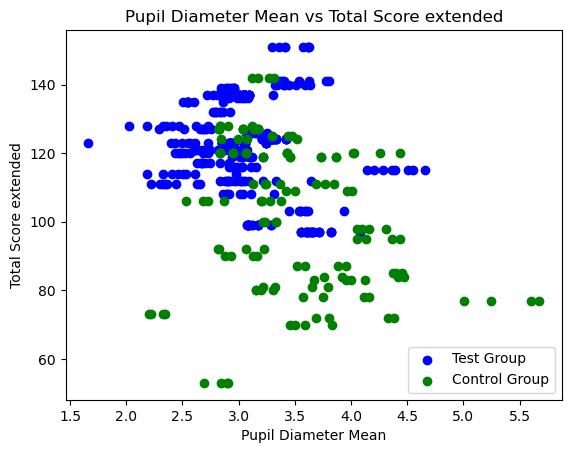

In [ ]:
def plot_graph(empathy_group_data, color_list, column_name):
    fig, ax = plt.subplots()

    for group, color in zip(empathy_groups, colors_legend):
        group_data = merge_empathy_data[merge_empathy_data['Experiment Group'] == group]
        ax.scatter(group_data[column_name[0]], group_data[column_name[1]], c=color, label=group)

    # Add labels and title
    ax.set_xlabel(column_name[0])
    ax.set_ylabel(column_name[1])
    ax.set_title('{} vs {}'.format(column_name[0],column_name[1]))

    ax.legend(loc='lower right')

    # Show the plot
    plt.show()

# Create a scatter plot with different colors for each project
empathy_groups = merge_empathy_data['Experiment Group'].unique()
colors_legend = ['blue', 'green']
column_name = ['Pupil Diameter Mean','Total Score extended']

plot_graph(empathy_groups,colors_legend, column_name)



The above scatter plot illustrates the relationship between the overall count of fixations and the empathy score for every participant group in the study. The data is organized by participant group, with each data point representing either a control or test experimental group.

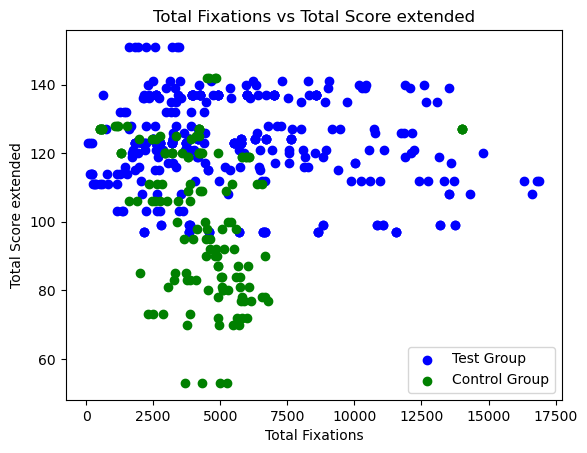

In [ ]:
# Next we repeat the above scatter plot to find relationship between Total Fixation and EmpathyScore
column_name = ['Total Fixations','Total Score extended']

plot_graph(empathy_groups,colors_legend, column_name)

### Standard diameters and the associated uncertainties for the trials conducted by each participant

The majority of participants have engaged in varying numbers of trials, showcasing diverse characteristics during these attempts.

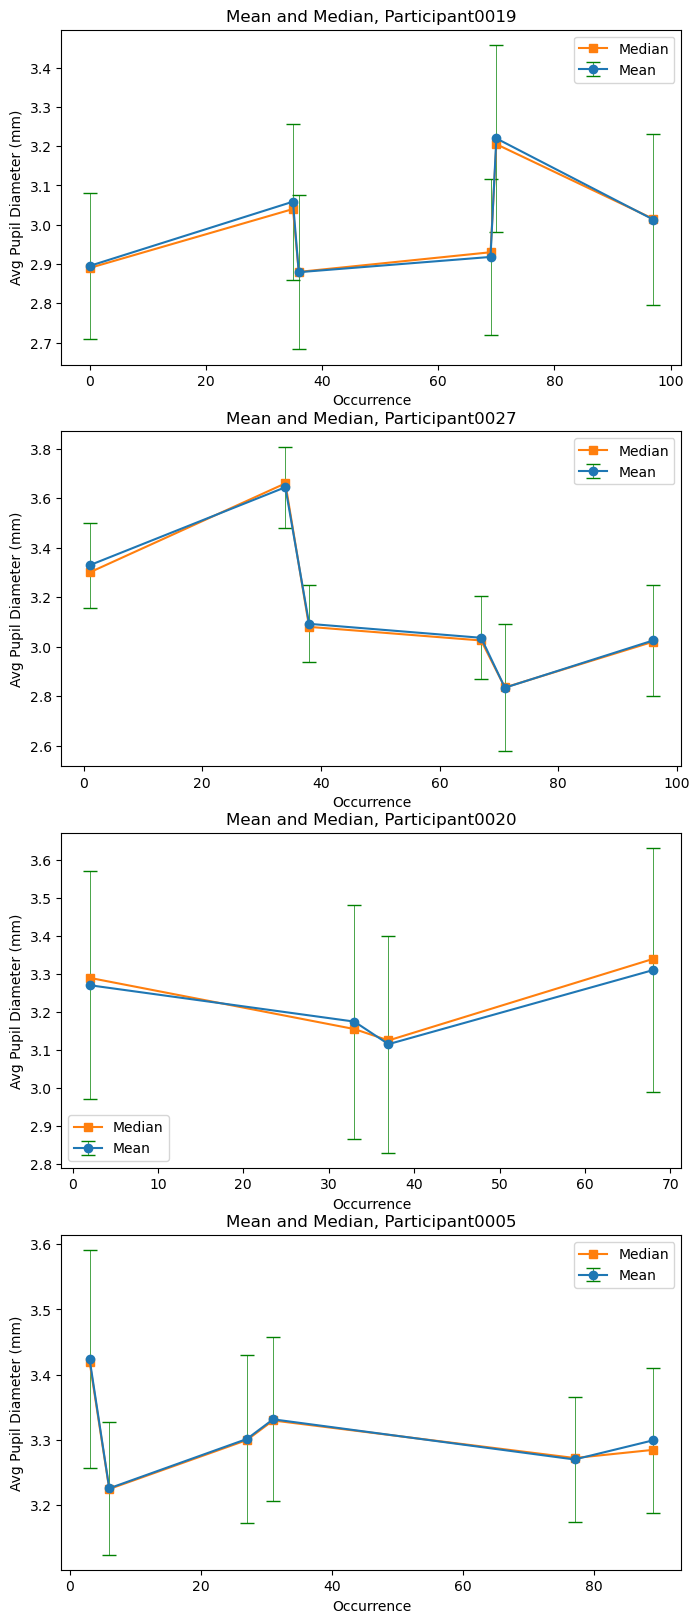

In [ ]:
# Get unique participant names and
# limit the number of participant to the first 4
unique_empathy_participants = merge_empathy_data['Participant Name'].unique()[:4]


# Create subplots
fig, axs = plt.subplots(nrows=len(unique_empathy_participants), figsize=(8, 5*len(unique_empathy_participants)))


for i, participant in enumerate(unique_empathy_participants):
    participant_info = merge_empathy_data[merge_empathy_data['Participant Name'] == participant]
    participant_info = participant_info.reset_index().rename(columns={'index': 'occurrence'}).head(6)

    grouped_data = participant_info.groupby('occurrence').agg({'Pupil Diameter Mean': 'mean', 'Pupil Diameter Median': 'mean', 'Pupil Diameter Std': 'mean'}).reset_index()

    ax = axs[i]

    ax.errorbar(grouped_data['occurrence'], grouped_data['Pupil Diameter Mean'], grouped_data['Pupil Diameter Std'], linestyle='-', marker='o', capsize=5, ecolor="green", elinewidth=0.5, label='Mean')

    ax.plot(grouped_data['occurrence'], grouped_data['Pupil Diameter Median'], linestyle='-', marker='s', label='Median')

    # Add labels and title
    ax.set_xlabel('Occurrence')
    ax.set_ylabel('Avg Pupil Diameter (mm)')
    ax.set_title(f'Mean and Median, {participant}')

    # Add legend
    ax.legend()

# Show the plot
plt.show()

### Separating Test group from Control Group

Given that gaze typing entails notably increased engagement of the eyes compared to the free-viewing group, it merits distinct consideration.

In [ ]:
# Create a dictionary to store records for each group
empathy_groups_dfs = {}

# Iterate over each unique group name
for group in empathy_groups:
    # Filter the data for the current project
    group_data = merge_empathy_data[merge_empathy_data['Experiment Group'] == group]

    # Add the filtered data to the dictionary with the project name as the key
    empathy_groups_dfs[group] = group_data

In [ ]:
# Access a specific experiment group's DataFrame by its name
empathy_group_name = 'Test Group'
empaty_test_df = empathy_groups_dfs[empathy_group_name]
empaty_test_df.head()

,Participant Name,Experiment Group,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std,Total Score extended
0,Participant0019,Test Group,Recording7,12745,455.327187,2.895178,2.890,0.185776,821.195288,837.0,313.824888,464.808016,424.0,296.155625,821.510586,837.0,315.173295,466.802887,422.0,299.916242,112
1,Participant0027,Test Group,Recording2,4066,241.332759,3.329009,3.300,0.172199,945.682106,911.0,386.043190,242.687839,217.0,260.315178,963.372552,916.0,411.777557,249.793043,225.0,263.201367,112
3,Participant0005,Test Group,Recording17,3236,249.046044,3.424232,3.420,0.166587,1071.803100,983.0,352.558180,438.694786,425.0,327.008193,1095.109816,1056.0,381.041937,460.701956,432.0,329.313225,124
4,Participant0057,Test Group,Recording2,2317,283.300388,3.344963,3.245,0.490158,1008.540733,1025.0,293.797887,383.615071,388.5,301.369884,1002.022812,1013.0,249.691787,395.671353,390.0,288.796322,140
6,Participant0005,Test Group,Recording20,5765,295.298873,3.226111,3.225,0.101390,887.239781,919.0,255.713059,594.222771,588.5,310.255028,887.853812,920.0,259.183492,598.576578,585.0,316.216039,124


In [ ]:
# Access a specific experiment group's DataFrame by its name
empathy_group_name = 'Control Group'
empaty_control_df = empathy_groups_dfs[empathy_group_name]
empaty_control_df.head()

,Participant Name,Experiment Group,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std,Total Score extended
2,Participant0020,Control Group,Recording1,4843,318.503200,3.270588,3.290,0.300009,876.003964,843.0,309.121051,434.685555,384.0,288.940635,876.342661,875.0,303.618117,435.228944,373.0,294.384420,142
5,Participant0012,Control Group,Recording2,2462,589.370024,2.846188,2.830,0.438101,970.183267,994.0,247.180256,497.298986,496.0,180.389146,959.004082,997.0,197.928929,542.699930,501.0,219.308611,124
14,Participant0004,Control Group,Recording6,1316,342.336626,2.952695,2.725,0.578240,1012.665897,973.0,225.310956,438.215040,429.0,253.141556,962.311529,913.0,161.681516,302.944344,361.0,265.285874,120
15,Participant0006,Control Group,Recording13,6067,322.309049,3.736822,3.745,0.184397,1081.985186,1082.0,287.657781,445.591859,464.0,271.484371,1080.023164,1081.0,286.496977,448.668247,462.0,273.931696,119
18,Participant0002,Control Group,Recording5,14005,226.378865,3.173286,3.135,0.317180,845.293367,876.0,366.839883,385.072714,362.0,261.964345,846.370786,889.0,366.096166,393.642371,378.0,253.708349,127


### Analyzing Pupil only

The assessment of empathy can be based on pupil characteristics. This method centers solely on the pupil to forecast empathy, disregarding potentially less dependable or pertinent attributes. Employing this strategy will furnish a holistic comprehension of empathy and facilitate more precise prognostications. In essence, leveraging pupil characteristics will offer a concentrated and meticulous assessment of empathy.

In [ ]:
empathy_pupil_test = empaty_test_df.loc[:, ['Participant Name', 'Pupil Diameter Mean', 'Pupil Diameter Median', 'Pupil Diameter Std', 'Experiment Group', 'Recording Name', 'Total Score extended']].copy()

# Print the first few rows of the new DataFrame
empathy_pupil_test.head()

,Participant Name,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Experiment Group,Recording Name,Total Score extended
0,Participant0019,2.895178,2.890,0.185776,Test Group,Recording7,112
1,Participant0027,3.329009,3.300,0.172199,Test Group,Recording2,112
3,Participant0005,3.424232,3.420,0.166587,Test Group,Recording17,124
4,Participant0057,3.344963,3.245,0.490158,Test Group,Recording2,140
6,Participant0005,3.226111,3.225,0.101390,Test Group,Recording20,124


In [ ]:
# Similarly for control
empathy_pupil_control = empaty_control_df.loc[:, ['Participant Name', 'Pupil Diameter Mean', 'Pupil Diameter Median', 'Pupil Diameter Std', 'Experiment Group', 'Recording Name', 'Total Score extended']].copy()

# Print the first few rows of the new DataFrame
empathy_pupil_control.head()

,Participant Name,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Experiment Group,Recording Name,Total Score extended
2,Participant0020,3.270588,3.290,0.300009,Control Group,Recording1,142
5,Participant0012,2.846188,2.830,0.438101,Control Group,Recording2,124
14,Participant0004,2.952695,2.725,0.578240,Control Group,Recording6,120
15,Participant0006,3.736822,3.745,0.184397,Control Group,Recording13,119
18,Participant0002,3.173286,3.135,0.317180,Control Group,Recording5,127


### In both trials, various forms of eye movements are engaged, and their measurements exhibit no correlation. Each trial will be regarded as a distinct and separate group

In [ ]:
# function that plot a correlation graph
def plot_empathy_correlation_heatmap(df, target_column, top_n=15):

    corr_matrix = df.corr()

    # Select the top_n columns with the highest correlation
    cols = corr_matrix.nlargest(top_n, target_column)[target_column].index

    cm = df[cols].corr()

    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(cm, annot=True, cmap='coolwarm')
    ax.set_title('Correlation matrix for ' + target_column)

    plt.show()

    return

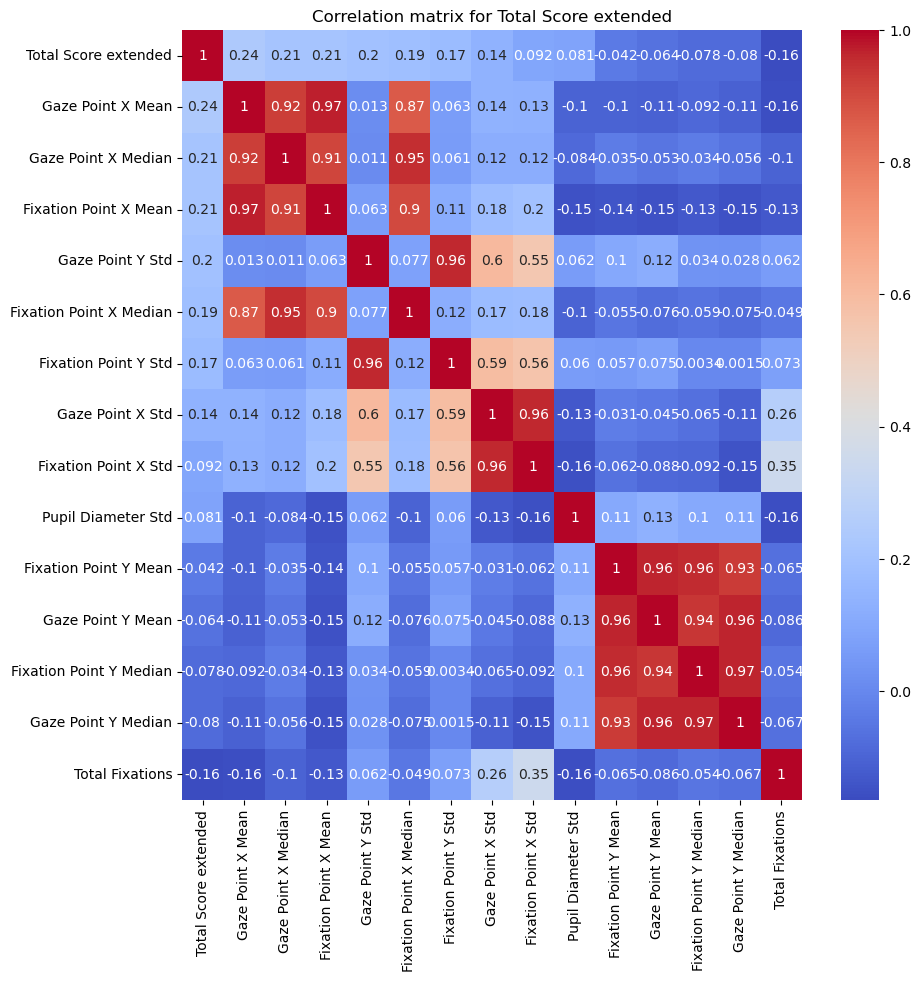

In [ ]:
# Plot
plot_empathy_correlation_heatmap(empaty_control_df, 'Total Score extended', top_n=15)

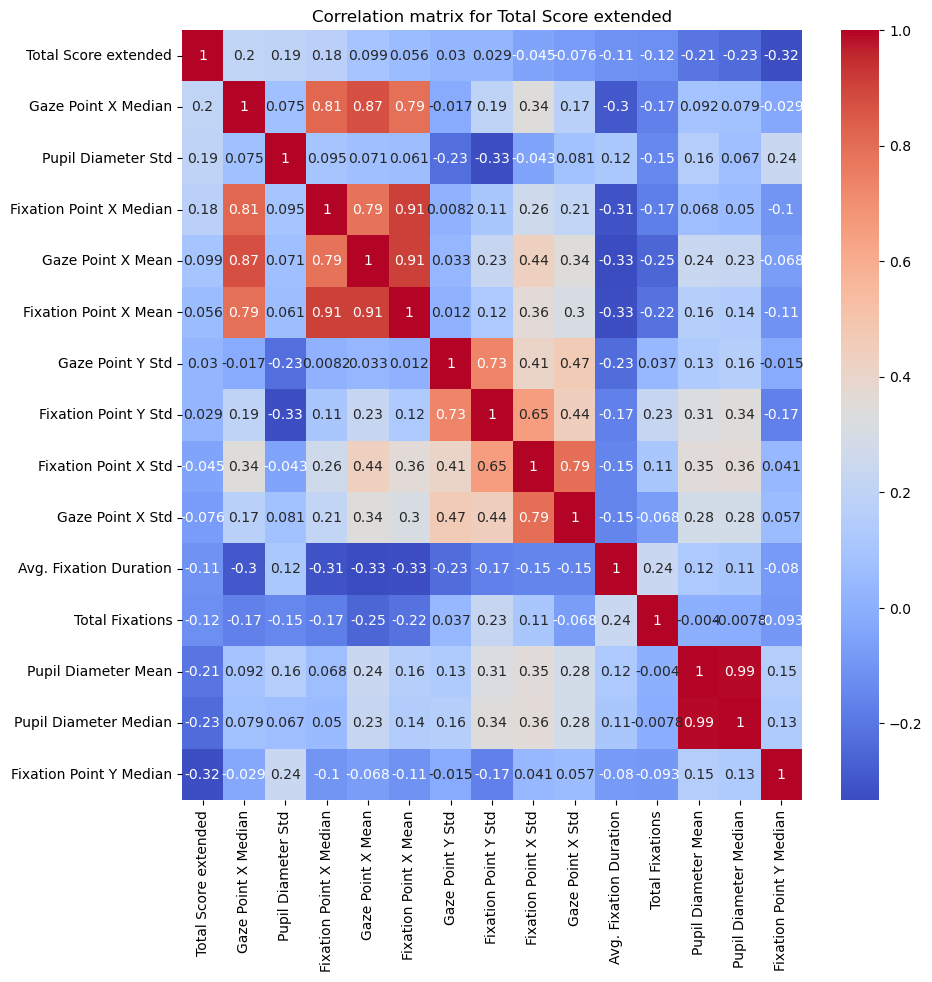

In [ ]:
# Plot
plot_empathy_correlation_heatmap(empaty_test_df, 'Total Score extended', top_n=15)

### Experiment 1

Deploying a "RandomForestRegressor" model using the "Group K-Fold cross-validation." This combination is applied to foresee empathy scores from the provided dataset, with subsequent assessment of the model's efficacy through diverse metrics. The primary objective centers on projecting empathy scores, leveraging the dataset's inherent attributes.

In [ ]:
# function to train and evaluate empathy dataset
def train_evalute_empathy(data_df, group_name):
    X = data_df.drop(columns=['Total Score extended', 'Experiment Group', 'Recording Name'])
    y = data_df['Total Score extended']
    results_df = pd.DataFrame(columns=['Participant Name', 'Original Empathy Score', 'Predicted Empathy Score'])
    # Encode the 'Participant Name' column
    encoder = LabelEncoder()
    X['Participant Name'] = encoder.fit_transform(X['Participant Name'])
    groups = data_df['Participant Name']

    n_splits = 30  # No of Participant
    gkf = GroupKFold(n_splits=n_splits)

    mse_scores = []
    r2_scores = []
    rt_MSE_scores = []
    medae_scores = []
    y_test_all = []  # Initialize y_test_all list
    y_pred_all = []  # Initialize y_pred_all list

    for fold, (train_index, test_index) in enumerate(gkf.split(X, y, groups=groups)):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        model = RandomForestRegressor()


        model.fit(X_train, y_train)
        #Make predictions and evaluate the model
        y_pred = model.predict(X_test)




        print(f"Fold {fold + 1}:")

        for idx, (original, predicted) in enumerate(zip(y_test, y_pred)):
            participant_name = data_df.iloc[test_index[idx]]['Participant Name']
            print(f"  Participant Name: {participant_name}, Orignal Empathy Score: {original}, Predicted empathy Score: {predicted:.2f}")
            results_df = results_df.append({'Participant Name': participant_name,'Original Empathy Score': original,'Predicted Empathy Score': predicted}, ignore_index=True)


        mse = mean_squared_error(y_test, y_pred)
        rt_MSE = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)

        mse_scores.append(mse)
        r2_scores.append(r2)
        rt_MSE_scores.append(rt_MSE)
        medae_scores.append(medae)
        y_test_all.extend(y_test)
        y_pred_all.extend(y_pred)


        # Calculate the average of evaluation matrics
    avg_r2 = np.mean(r2_scores)
    avg_rt = np.mean(rt_MSE_scores)
    avg_medae = np.mean(medae_scores)
    avg_mse_scores = np.mean(mse_scores)


    print(f"Average Rt mean sqr error: {avg_rt}")
    print(f"Average Median Abs error: {avg_medae}")
    print(f"Average Mean Squared Error: {avg_mse_scores}")



    return results_df

In [ ]:
empathy_control_result = train_evalute_empathy(empaty_control_df, "Control Group")

Fold 1:
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 126.78
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 108.58
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 121.93
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 121.71
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 108.58
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 126.78
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 121.93
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 121.71
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 126.78
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 108.58
  Participant Name: Pa

In [ ]:
empathy_test_result = train_evalute_empathy(empaty_test_df, "Test Group")

Fold 1:
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 126.41
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 130.17
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 128.67
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 130.02
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 128.11
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 125.57
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 128.57
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 127.87
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 130.17
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 126.41
  Participant Name: Pa

### Plot Graph of Actual vs Predicted

In [ ]:
def plot_actual_vs_predicted(dataframe):
    y_test_all = dataframe['Original Empathy Score'].tolist()
    y_pred_all = dataframe['Predicted Empathy Score'].tolist()

    plt.scatter(y_test_all, y_pred_all, color='blue', label='Predicted')
    plt.xlabel('Original Empathy Scores')
    plt.ylabel('Predicted Empathy Scores')
    plt.title('Original vs. Predicted Empathy Scores ')

    # Add a perfect prediction line
    min_val = min(min(y_test_all), min(y_pred_all))
    max_val = max(max(y_test_all), max(y_pred_all))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Perfect Prediction')

    plt.legend()
    plt.show()

    return

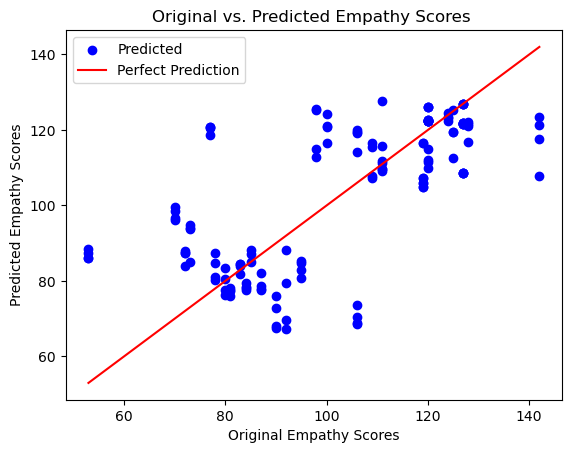

In [ ]:
# plot actual vs predicted for the control group
plot_actual_vs_predicted(empathy_control_result)

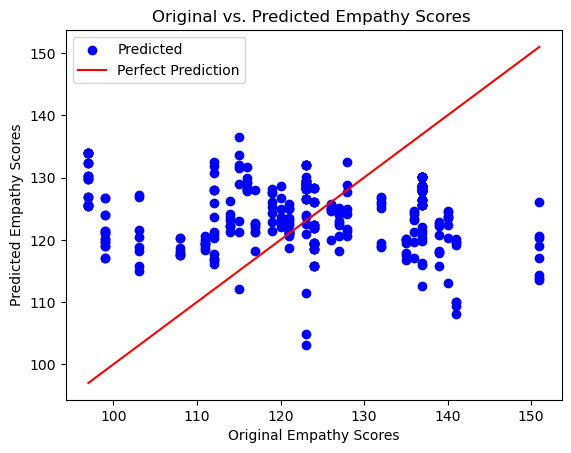

In [ ]:
# plot actual vs predicted for the test group
plot_actual_vs_predicted(empathy_test_result)

## Empathy Prediction

Compute the mean empathy score for every participant's trial to establish the collective projected empathy level

In [ ]:
def compute_participant_empathy_score(df):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    # Group and calculate mean empathy scores
    results_test_mean = df.groupby('Participant Name').agg(
        Original_Empathy_Score=pd.NamedAgg(column='Original Empathy Score', aggfunc='first'),
        Predicted_Empathy_Score=pd.NamedAgg(column='Predicted Empathy Score', aggfunc='mean')
    )

    print("Grouped DataFrame:")
    print(results_test_mean)

    # Melt the DataFrame
    melted_df = results_test_mean.reset_index().melt(id_vars=['Participant Name'],
                                                     value_vars=['Original_Empathy_Score', 'Predicted_Empathy_Score'],
                                                     var_name='Score_Type', value_name='Score')

    # Display data for the first few participants
    first_n_participants = melted_df['Participant Name'].unique()[:7]
    filtered_df = melted_df[melted_df['Participant Name'].isin(first_n_participants)]

    # Plot the data
    plt.figure(figsize=(10, 5))
    sns.barplot(data=filtered_df, x='Participant Name', y='Score', hue='Score_Type')

    plt.title('Bar Plot of Actual and Predicted Empathy Scores for the First Few Participants')
    plt.xlabel('Participant Name')
    plt.ylabel('Empathy Score')

    plt.show()


Grouped DataFrame:
                 Original_Empathy_Score  Predicted_Empathy_Score
Participant Name                                                
Participant0002                     127               119.750000
Participant0004                     120               123.347500
Participant0006                     119               108.710000
Participant0008                      98               119.625000
Participant0010                     100               120.647500
Participant0012                     124               123.397500
Participant0014                     128               120.375000
Participant0016                     106               118.202500
Participant0018                     111               115.095000
Participant0020                     142               117.580000
Participant0022                     125               119.217500
Participant0024                     120               112.170000
Participant0026                     111               111.496667
Partic

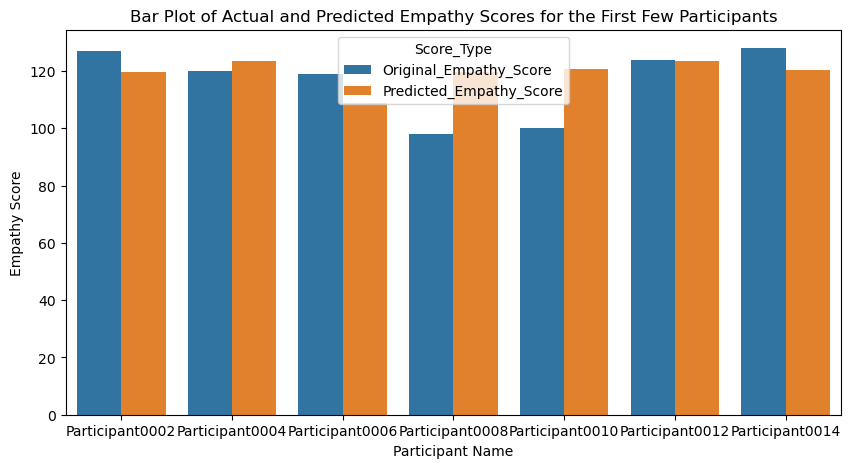

In [ ]:
# compute control group participants
compute_participant_empathy_score(empathy_control_result)

Grouped DataFrame:
                 Original_Empathy_Score  Predicted_Empathy_Score
Participant Name                                                
Participant0001                     137                128.17375
Participant0003                     123                128.81875
Participant0005                     124                121.49250
Participant0007                      97                129.78250
Participant0009                      99                121.13875
Participant0011                     151                118.08875
Participant0013                     117                122.34375
Participant0015                     137                118.67000
Participant0017                     123                117.56000
Participant0019                     112                128.58875
Participant0021                     114                123.15125
Participant0023                     141                114.47875
Participant0025                     120                124.33750
Partic

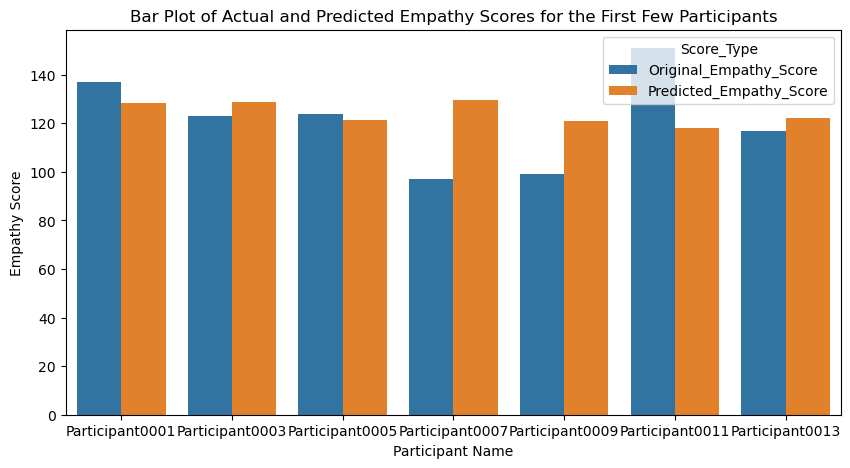

In [ ]:
# compute test group participants
compute_participant_empathy_score(empathy_test_result)

## Experiment 2 (concerns the Pupil Only)

In [ ]:
empathy_pupil_test

,Participant Name,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Experiment Group,Recording Name,Total Score extended
0,Participant0019,2.895178,2.8900,0.185776,Test Group,Recording7,112
1,Participant0027,3.329009,3.3000,0.172199,Test Group,Recording2,112
3,Participant0005,3.424232,3.4200,0.166587,Test Group,Recording17,124
4,Participant0057,3.344963,3.2450,0.490158,Test Group,Recording2,140
6,Participant0005,3.226111,3.2250,0.101390,Test Group,Recording20,124
7,Participant0015,3.012964,3.0800,0.327040,Test Group,Recording1,137
8,Participant0007,3.819665,3.8150,0.184683,Test Group,Recording26,97
9,Participant0007,3.642740,3.6500,0.230516,Test Group,Recording32,97
10,Participant0001,2.953567,2.9550,0.113474,Test Group,Recording8,137
11,Participant0003,2.930768,2.9400,0.216362,Test Group,Recording12,123


In [ ]:
pupil_control_result = train_evalute_empathy(empathy_pupil_control, "Control Group")

Fold 1:
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 126.00
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 120.78
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 119.70
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 123.27
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 120.78
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 126.00
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 119.70
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 123.27
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 126.00
  Participant Name: Participant0002, Orignal Empathy Score: 127, Predicted empathy Score: 120.78
  Participant Name: Pa

Grouped DataFrame:
                 Original_Empathy_Score  Predicted_Empathy_Score
Participant Name                                                
Participant0002                     127               122.437500
Participant0004                     120               121.977500
Participant0006                     119               117.297500
Participant0008                      98               122.575000
Participant0010                     100               114.645000
Participant0012                     124               123.732500
Participant0014                     128               121.745000
Participant0016                     106               116.362500
Participant0018                     111               115.837500
Participant0020                     142               120.097500
Participant0022                     125               117.180000
Participant0024                     120               110.617500
Participant0026                     111               118.883333
Partic

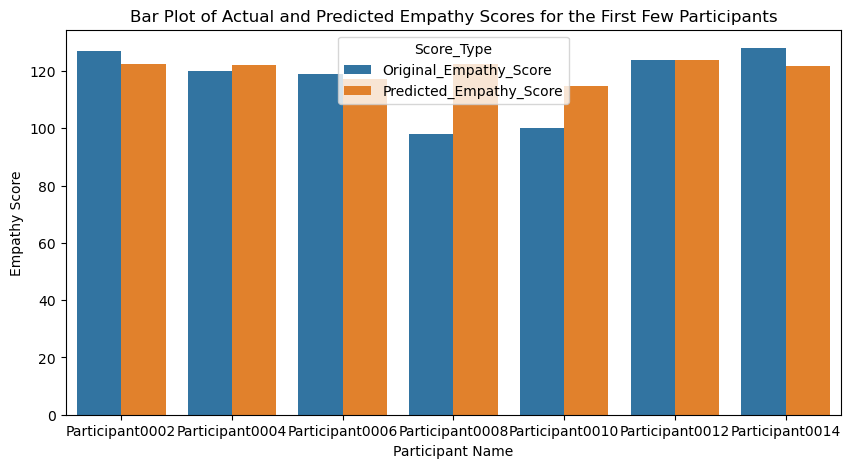

In [ ]:
# compute control group for pupil only
compute_participant_empathy_score(pupil_control_result)

In [ ]:
pupil_test_result = train_evalute_empathy(empathy_pupil_test, "Test Group")

Fold 1:
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 122.29
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 123.15
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 121.79
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 122.50
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 121.97
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 122.82
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 122.80
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 122.81
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 123.15
  Participant Name: Participant0001, Orignal Empathy Score: 137, Predicted empathy Score: 122.29
  Participant Name: Pa

Grouped DataFrame:
                 Original_Empathy_Score  Predicted_Empathy_Score
Participant Name                                                
Participant0001                     137                122.51625
Participant0003                     123                137.00000
Participant0005                     124                123.95750
Participant0007                      97                126.65000
Participant0009                      99                123.43500
Participant0011                     151                104.11375
Participant0013                     117                134.69500
Participant0015                     137                117.51250
Participant0017                     123                132.94750
Participant0019                     112                124.49375
Participant0021                     114                120.82625
Participant0023                     141                108.93625
Participant0025                     120                116.11875
Partic

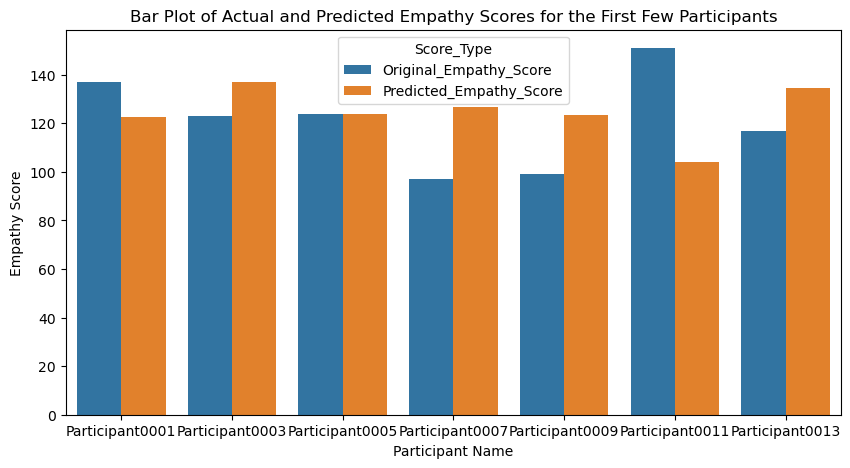

In [ ]:
# compute test group for pupil only
compute_participant_empathy_score(pupil_test_result)